# Parameters

In [ ]:
# what fold to use
# 1 - original fold 1
# 10 - oversampled fold 1
# 11 - sampled using DCGAN fold 1
my_fold = 11
my_type = 'age'

In [ ]:
PATH_TO_FOLDS = "/content/ds/train_val_txt_files_per_fold"
PATH_TO_DATA = "/content/ds"
PATH_TO_IMAGE_FOLDERS = PATH_TO_DATA + "/aligned"
PATH_TO_MODELS = "/content/ds/models"

In [ ]:
minibatch_size = 50
num_epochs = 20
lr = 0.0001

# Download dataset and supplementary data


In [ ]:
$username = 'adiencedb'
$password = 'XXX'

In [ ]:
url_ds = 'http://' + username + ':' + password + '@www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/aligned.tar.gz'
url_gen1 = 'https://github.com/dyussekeyev/age-and-gender-classification/raw/main/generated/generated1.zip'
url_gen1 = 'https://github.com/dyussekeyev/age-and-gender-classification/raw/main/generated/generated2.zip'
url_folds = 'https://github.com/dyussekeyev/age-and-gender-classification/raw/main/by-age/train_val_txt_files_per_fold.zip'

!mkdir /content/ds/
!mkdir /content/ds/models/

!wget $url_ds
!wget $url_gen1
!wget $url_gen2
!wget $url_folds

!tar -xzf "/content/aligned.tar.gz" -C "/content/ds/"
!unzip "/content/generated1.zip" -d "/content/ds/aligned"
!unzip "/content/generated2.zip" -d "/content/ds/aligned"
!unzip "/content/train_val_txt_files_per_fold.zip" -d "/content/ds"

# Imports

In [ ]:
import torch
import torch.autograd.variable as Variable
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as utils
from torch.utils.data import Dataset, DataLoader

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from shutil import copyfile

# Load Dataset

In [ ]:
class AdienceDataset(Dataset):    
    def __init__(self, txt_file, root_dir, transform):
        self.txt_file = txt_file
        self.root_dir = root_dir
        self.transform = transform
        self.data = self.read_from_txt_file()
    
    def __len__(self):
        return len(self.data)

    def read_from_txt_file(self):
        data = []
        f = open(self.txt_file)
        for line in f.readlines():
            image_file, label = line.split()
            label = int(label)
            if 'gender' in self.txt_file:
                label += 8
            data.append((image_file, label))
        return data
    
    def __getitem__(self, idx):
        img_name, label = self.data[idx]
        image = Image.open(self.root_dir + '/' + img_name)
        
        if self.transform:
            image = self.transform(image)
            
        return {
            'image': image,
            'label': label
        }

In [ ]:
transforms_list = [
    transforms.Resize(64),
    transforms.CenterCrop(60),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.RandomCrop(60)
]

transforms_dict = {
    'train': {
        0: list(transforms_list[i] for i in [0, 1, 3]),        # no transformation
        1: list(transforms_list[i] for i in [0, 1, 2, 3]),     # random horizontal flip
        2: list(transforms_list[i] for i in [0, 4, 2, 3])      # random crop and random horizontal flip
    },
    'val': {
        0: list(transforms_list[i] for i in [0, 1, 3])
    },
    'test': {
        0: list(transforms_list[i] for i in [0, 1, 3])
    }
}

In [ ]:
def get_dataloader(s, c, fold, transform_index, minibatch_size):
    txt_file = f'{PATH_TO_FOLDS}/test_fold_is_{fold}/{c}_{s}.txt'
    root_dir = PATH_TO_IMAGE_FOLDERS
    
    transformed_dataset = AdienceDataset(txt_file, root_dir,
                                         transforms.Compose(transforms_dict[s][transform_index]))
    dataloader = DataLoader(transformed_dataset, batch_size=minibatch_size, shuffle=True, num_workers=2)
    
    return dataloader

# Model

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 96, 7, stride = 4, padding = 1)
        self.pool1 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm1 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.conv2 = nn.Conv2d(96, 256, 5, stride = 1, padding = 2)
        self.pool2 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm2 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.conv3 = nn.Conv2d(256, 384, 3, stride = 1, padding = 1)
        self.pool3 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm3 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.fc1 = nn.Linear(1536, 512)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, 512)
        self.dropout2 = nn.Dropout(0.5)
  
        self.fc3 = nn.Linear(512, 10)
    
        self.apply(weights_init)

    
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = self.pool1(x)
        x = self.norm1(x)

        x = F.leaky_relu(self.conv2(x))
        x = self.pool2(x)
        x = self.norm2(x)
      
        x = F.leaky_relu(self.conv3(x))
        x = self.pool3(x)
        x = self.norm3(x)
      
        x = x.view(-1, 1536)
        
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.dropout1(x)
      
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.dropout2(x)
      
        x = F.log_softmax(self.fc3(x), dim=1)
  
        return x


In [ ]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=1e-2)

In [ ]:
criterion = nn.NLLLoss()

# Train

In [ ]:
def train(net, train_dataloader, epochs, filename, checkpoint_frequency, val_dataloader=None):
    """
    Args:
        net: An instance of PyTorch's Net class.
        train_dataloader: An instance of PyTorch's Dataloader class.
        epochs: An integer.
        filename: A string. Name of the model saved to drive.
        checkpoint_frequency: An integer. Represents how frequent (in terms
            of number of iterations) the model should be saved to drive.
        val_dataloader: An instance of PyTorch's Dataloader class.
    
    Returns:
        net: An instance of PyTorch's Net class. The trained network.
        training_loss: A list of numbers that represents the training loss at each checkpoint.
        validation_loss: A list of numbers that represents the validation loss at each checkpoint.
    """
    net.train()
    optimizer = optim.Adam(net.parameters(), lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000])
    
    training_loss, validation_loss = [], []
    checkpoint = 0
    iteration = 0
    running_loss = 0
    
    for epoch in range(epochs):

        for i, batch in enumerate(train_dataloader):
            #scheduler.step()
            optimizer.zero_grad()
            images, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss += float(loss.item())
            loss.backward()
            optimizer.step()
            scheduler.step() # added due to warning of PyTorch >1.1.0

            if (iteration+1) % checkpoint_frequency == 0 and val_dataloader is not None:
                training_loss.append(running_loss/checkpoint_frequency)
                validation_loss.append(validate(net, val_dataloader))
                print(f'minibatch:{i}, epoch:{epoch}, iteration:{iteration}, training_error:{training_loss[-1]}, validation_error:{validation_loss[-1]}')
                save_network(net, f'{filename}_checkpoint{checkpoint}')
                checkpoint += 1
                running_loss = 0
            
            iteration += 1

    return net, training_loss, validation_loss


# Validate

In [ ]:
def validate(net, dataloader):
    net.train()
    total_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            images, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            total_loss += float(loss.item())

    return total_loss/(i+1)


In [ ]:
def get_validation_error(c, fold, train_transform_index):
    filename = get_model_filename(c, fold, train_transform_index)
    net = Net().to(device)
    net.load_state_dict(torch.load(f'{PATH_TO_MODELS}/{filename}'))
    return validate(net, get_dataloader('val', c, fold, 0, minibatch_size))


# Test

In [ ]:
def test(net, dataloader, c):
    result = {
        'exact_match': 0,
        'total': 0
    }
    if c == 'age':
        result['one_off_match'] = 0

    with torch.no_grad():
        net.eval()
        for i, batch in enumerate(dataloader):
            images, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = net(images)
            outputs = torch.tensor(list(map(lambda x: torch.max(x, 0)[1], outputs))).to(device)
            result['total'] += len(outputs)
            result['exact_match'] += sum(outputs == labels).item()
            if c == 'age':
                result['one_off_match'] += (sum(outputs==labels) +
                                            sum(outputs==labels-1) +
                                            sum(outputs==labels+1)).item()

    return result

# Save the model

In [ ]:
def save_network(net, filename):
    torch.save(net.state_dict(), f'{PATH_TO_MODELS}/{filename}.pt')

# Execution

In [ ]:
def train_save(c, fold, train_transform_index, checkpoint_frequency=50):
    """
    Args:
        c: A string. Equals either "age" or "gender".
        fold: An integer. Lies in the range [0, 4] as there are five folds present.
        train_transform_index: An integer. The transforms in the list correesponding
            to this index in the dictionary will be applied on the images.
        checkpoint_frequency: An integer. Represents how frequent (in terms
            of number of iterations) the model should be saved to drive.   
    Returns:
        validation_loss: A list of numbers that represents the validation loss at each checkpoint.
    """
    trained_net, training_loss, validation_loss = train(
        Net().to(device),
        get_dataloader('train', c, fold, train_transform_index, minibatch_size),
        num_epochs,
        f'{fold}_{c}_train_{train_transform_index}',
        checkpoint_frequency,
        get_dataloader('val', c, fold, 0, minibatch_size)
    )
    
    plt.plot(list(map(lambda x: checkpoint_frequency * x, (list(range(1, len(validation_loss)+1))))), validation_loss, label='validation_loss')
    plt.plot(list(map(lambda x: checkpoint_frequency * x, (list(range(1, len(training_loss)+1))))), training_loss, label='training_loss')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.show()
    
    choose_model_with_least_val_error(c, fold, train_transform_index, validation_loss)
    
    return validation_loss


In [ ]:
def choose_model_with_least_val_error(c, fold, train_transform_index, validation_loss):
    index = validation_loss.index(min(validation_loss))
    filename = f'{fold}_{c}_train_{train_transform_index}'
    for file in os.listdir(PATH_TO_MODELS):
        if file.startswith(filename):
            if file.startswith(f'{filename}_checkpoint{index}'):
                pass
            else:
                os.remove(f'{PATH_TO_MODELS}/{file}')


In [ ]:
def pick_best_model(c):
    """
    Args:
        s: A string. Equals either "train", "val", or "test".
        c: A string. Equals either "age" or "gender".
    """
    def fn_filter(file):
        file_split = file.split('_')
        return True if (len(file_split) == 5 and file_split[1] == c) else False
    
    def fn_map(file):
        file_split = file.split('_')
        return get_validation_error(c, file_split[0], file_split[3])
    
    files = list(filter(fn_filter, os.listdir(PATH_TO_MODELS)))
    val_errors = list(map(fn_map, files))
    min_val_error, file = min(zip(val_errors, files))
    best_model = f'{PATH_TO_MODELS}/{file.split(".")[0]}_best.pt'
    copyfile(f'{PATH_TO_MODELS}/{file}', best_model)
    
    print(f'Picking {best_model} as the best model for {c}...')


# Performance and Accuracy

In [ ]:
def get_performance(c):
    """
    Args:
        c: A string. Equals either "age" or "gender".
    Returns:
        A dictionary containing accuracy (and one-off accuracy for age) of the model.
    """    
    file = get_best_model_filename(c).split('_')
    return get_performance_of_a_model('test', file[1], file[0], file[3])


In [ ]:
def get_best_model_filename(c):
    def fn_filter(file):
        file_split = file.split('_')
        return True if (len(file_split) == 6 and file_split[1] == c) else False
    
    return list(filter(fn_filter, os.listdir(PATH_TO_MODELS)))[0]


In [ ]:
def get_performance_of_a_model(s, c, fold, train_transform_index):
    filename = get_model_filename(c, fold, train_transform_index)
    net = Net().to(device)
    net.load_state_dict(torch.load(f'{PATH_TO_MODELS}/{filename}'))
    performance = test(
        net,
        get_dataloader(s, c, fold, 0, minibatch_size),
        c
    )
    if c == 'age':
        return {
            'accuracy': performance['exact_match']/performance['total'],
            'one-off accuracy': performance['one_off_match']/performance['total']
        }
    elif c == 'gender':
        return {
            'accuracy': performance['exact_match']/performance['total']
        }

In [ ]:
def get_model_filename(c, fold, train_transform_index):
    start_of_filename = f'{fold}_{c}_train_{train_transform_index}_checkpoint'
    for file in os.listdir(PATH_TO_MODELS):
        if file.startswith(start_of_filename):
            return file

# Job

minibatch:49, epoch:0, iteration:49, training_error:2.195938482284546, validation_error:2.1222604604867787
minibatch:99, epoch:0, iteration:99, training_error:2.104954342842102, validation_error:2.100322750898508
minibatch:149, epoch:0, iteration:149, training_error:2.1054009103775027, validation_error:2.0978881487479577
minibatch:199, epoch:0, iteration:199, training_error:2.0951499128341675, validation_error:2.083191156387329
minibatch:249, epoch:0, iteration:249, training_error:2.1011373472213744, validation_error:2.077675177500798
minibatch:299, epoch:0, iteration:299, training_error:2.088511052131653, validation_error:2.0954598096700816
minibatch:349, epoch:0, iteration:349, training_error:2.0909236431121827, validation_error:2.091859193948599
minibatch:399, epoch:0, iteration:399, training_error:2.0915154886245726, validation_error:2.0805088923527646
minibatch:449, epoch:0, iteration:449, training_error:2.0887950897216796, validation_error:2.068839064011207
minibatch:11, epoch:1,

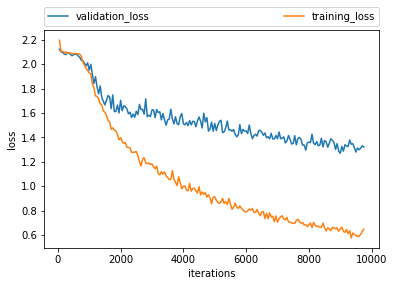

In [ ]:
val_loss = train_save(my_type, my_fold, 2)

In [ ]:
pick_best_model(my_type)

Picking /content/ds/models//11_age_train_2_checkpoint179_best.pt as the best model for age...


In [ ]:
get_performance(my_type)

{'accuracy': 0.47659870250231695, 'one-off accuracy': 0.7680722891566265}

In [ ]:
sprint(val_loss)

[2.1222604604867787, 2.100322750898508, 2.0978881487479577, 2.083191156387329, 2.077675177500798, 2.0954598096700816, 2.091859193948599, 2.0805088923527646, 2.068839064011207, 2.077556775166438, 2.081287008065444, 2.0798369554372935, 2.0670505945499125, 2.0547941464644213, 2.031362157601577, 2.027265865069169, 2.0067942921931925, 1.9863307980390696, 2.0105643547498264, 1.9502190947532654, 1.9989078411689172, 1.9142428957498991, 1.842538214646853, 1.8976891728547902, 1.8121605148682227, 1.757250006382282, 1.8216838332322927, 1.7270337297366216, 1.6963053666628325, 1.6661051236666167, 1.7051871464802668, 1.7433989368952238, 1.7306684438998883, 1.635620612364549, 1.7481659650802612, 1.6117055645355811, 1.6126827460068922, 1.6650823263021617, 1.6004302180730379, 1.7038294076919556, 1.6183619132408729, 1.6601351591256948, 1.6517084699410658, 1.6342976597639232, 1.59339774113435, 1.6066318612832289, 1.5639949257557209, 1.5916557495410626, 1.5651348875119135, 1.6149529356222887, 1.58618288773